# Taiwan Election Prediction: Clustering Analysis

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Clustering
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

warnings.filterwarnings('ignore')

# Set plot style
#plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'Arial Unicode MS']
#plt.rcParams['axes.unicode_minus'] = False
sns.set_style('whitegrid')
sns.set_palette('husl')

## 1. Load and Prepare Data

In [2]:
# Load cleaned data
df = pd.read_csv('../data/processed/cleaned_data.csv')

print(f"Data shape: {df.shape}")
print(f"Districts: {len(df)}")
df.head()

Data shape: (20, 30)
Districts: 20


,District,Winner,Total_Votes,Ko_Wu,Ko_Wu_Pct,Lai_Hsiao,Lai_Hsiao_Pct,Hou_Chao,Hou_Chao_Pct,Total_Population,...,Avg_People_Per_HH,Total_15Plus,Higher_Education_Pct,Graduate_Pct,College_Pct,JuniorCollege_Pct,HighSchool_Pct,Junior_Pct,Primary_Pct,Illiterate_Pct
0,Taipei City,Lai_Hsiao,1542011,366854,23.79,587899,38.13,587258,38.08,4041869.0,...,2.71,2187844,65.72,15.25,38.23,12.24,21.97,6.24,5.69,0.39
1,New Taipei City,Lai_Hsiao,2458480,645105,26.24,948818,38.59,864557,35.17,2511291.0,...,2.75,3601907,51.90,8.59,31.64,11.67,28.58,11.71,7.26,0.55
2,Taoyuan City,Lai_Hsiao,1350792,413528,30.61,476441,35.27,460823,34.12,2319118.0,...,2.99,2024131,51.55,8.44,32.43,10.68,30.55,10.22,7.05,0.63
3,Taichung City,Lai_Hsiao,1707203,513025,30.05,641622,37.58,552556,32.37,2847264.0,...,2.82,2488030,52.67,8.98,32.45,11.24,29.31,10.02,7.37,0.64
4,Tainan City,Lai_Hsiao,1120238,262560,23.44,570811,50.95,286867,25.61,1859800.0,...,2.81,1650022,49.01,8.81,30.34,9.85,28.30,10.95,10.90,0.85


In [5]:
# Select features for clustering
clustering_features = [
    # Demographics
    'Age_0_14_Pct', 'Age_15_64_Pct', 'Age_65_Plus_Pct',
    # Economics
    'Income', 'Disposable_Income', 'Consumption',
    # Education
    'Higher_Education_Pct', 'Graduate_Pct',
    # Household
    'Avg_People_Per_HH',
    # Voting 
    'Lai_Hsiao_Pct', 'Hou_Chao_Pct', 'Ko_Wu_Pct'
]

X_cluster = df[clustering_features].copy()
districts = df['District'].values
winners = df['Winner'].values

print(f"Clustering features: {len(clustering_features)}")
print(f"\nFeature list:")
for i, feat in enumerate(clustering_features, 1):
    print(f"  {i}. {feat}")

Clustering features: 12

Feature list:
  1. Age_0_14_Pct
  2. Age_15_64_Pct
  3. Age_65_Plus_Pct
  4. Income
  5. Disposable_Income
  6. Consumption
  7. Higher_Education_Pct
  8. Graduate_Pct
  9. Avg_People_Per_HH
  10. Lai_Hsiao_Pct
  11. Hou_Chao_Pct
  12. Ko_Wu_Pct


In [6]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

print("Features standardized!")
print(f"  Mean: {X_scaled.mean():.3f}")
print(f"  Std: {X_scaled.std():.3f}")

Features standardized!
  Mean: 0.000
  Std: 1.000


## 2. Determine Optimal Number of Clusters

### 2.1 Elbow Method

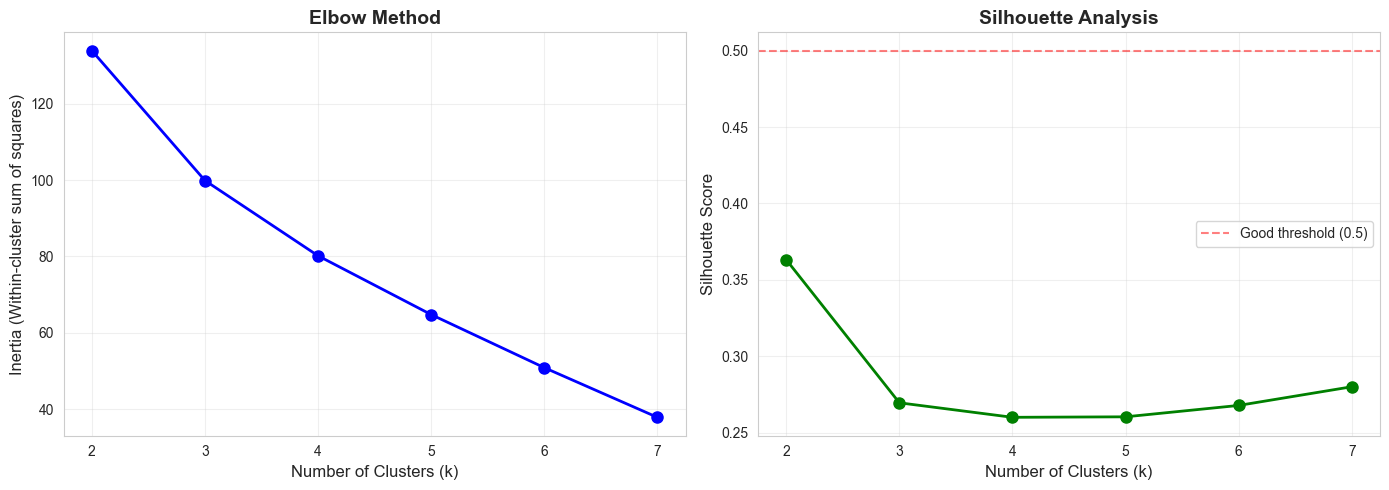


Optimal number of clusters: 2
Silhouette score: 0.363


In [7]:
# Calculate inertia for different k values
inertias = []
silhouette_scores = []
K_range = range(2, 8)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot elbow curve and silhouette scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow plot
axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Inertia (Within-cluster sum of squares)', fontsize=12)
axes[0].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Silhouette plot
axes[1].plot(K_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Analysis', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Good threshold (0.5)')
axes[1].legend()

plt.tight_layout()
plt.savefig('../results/figures/clustering_optimization.png', dpi=300, bbox_inches='tight')
plt.show()

# Find optimal k
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters: {optimal_k}")
print(f"Silhouette score: {max(silhouette_scores):.3f}")

### 2.2 Hierarchical Clustering Dendrogram

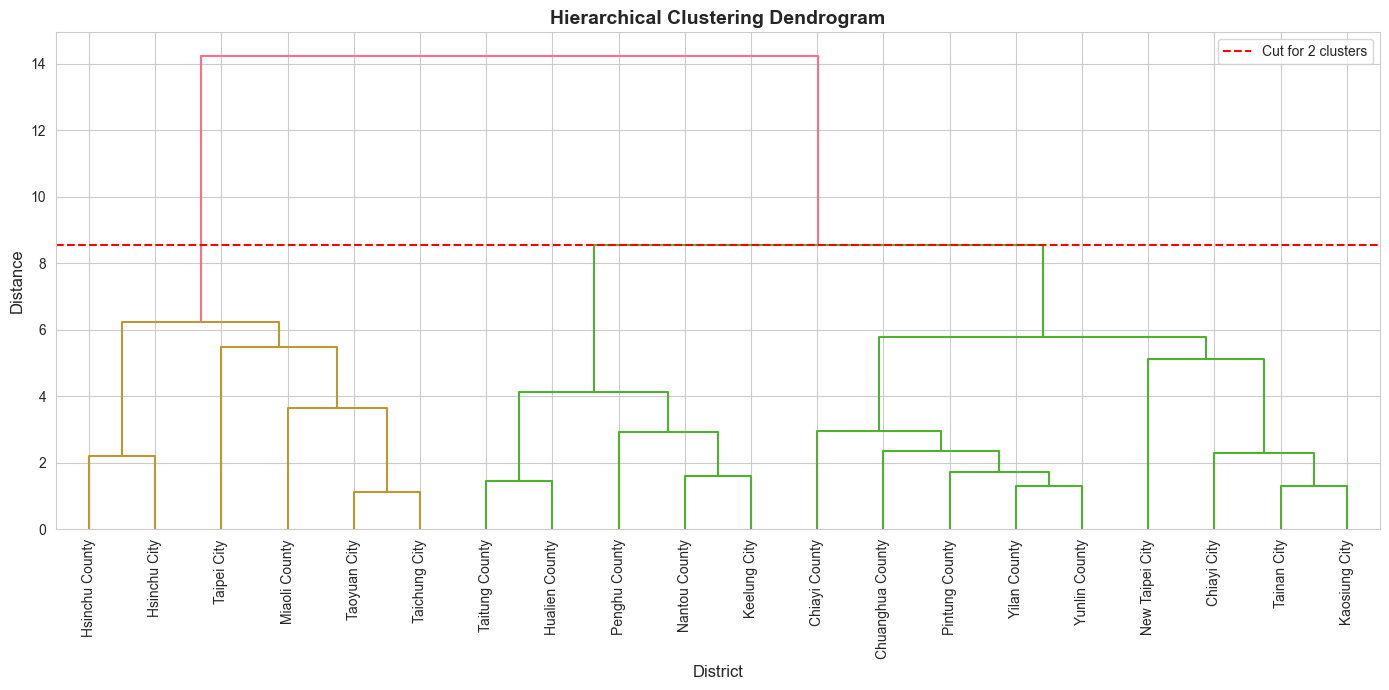

In [10]:
# Perform hierarchical clustering
linkage_matrix = linkage(X_scaled, method='ward')

# Plot dendrogram
plt.figure(figsize=(14, 7))
dendrogram(
    linkage_matrix,
    labels=districts,
    leaf_rotation=90,
    leaf_font_size=10
)
plt.xlabel('District', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.title('Hierarchical Clustering Dendrogram', fontsize=14, fontweight='bold')
cut_height = linkage_matrix[-2, 2]  
plt.axhline(y=cut_height, color='r', linestyle='--', label=f'Cut for {optimal_k} clusters')
plt.legend()
plt.tight_layout()
plt.savefig('../results/figures/dendrogram.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. K-Means Clustering

In [ ]:
# Perform K-Means with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to dataframe
df['Cluster'] = clusters

print(f"K-Means clustering complete!")
print(f"\nCluster distribution:")
print(df['Cluster'].value_counts().sort_index())

print(f"\nClusters by district:")
for cluster_id in range(optimal_k):
    cluster_districts = df[df['Cluster'] == cluster_id]['District'].values
    print(f"\nCluster {cluster_id}: {', '.join(cluster_districts)}")

K-Means clustering complete!

Cluster distribution:
Cluster
0    14
1     6
Name: count, dtype: int64

Clusters by district:

Cluster 0: New Taipei City, Tainan City, Kaosiung City, Yilan County, Miaoli County, Chuanghua County, Nantou County, Yunlin County, Chiayi County, Pintung County, Taitung County, Hualien County, Penghu County, Keelung City

Cluster 1: Taipei City, Taoyuan City, Taichung City, Hsinchu County, Hsinchu City, Chiayi City


## 4. PCA Visualization

In [11]:
# Perform PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"PCA explained variance:")
print(f"  PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"  PC2: {pca.explained_variance_ratio_[1]:.2%}")
print(f"  Total: {pca.explained_variance_ratio_.sum():.2%}")

PCA explained variance:
  PC1: 59.72%
  PC2: 17.66%
  Total: 77.38%


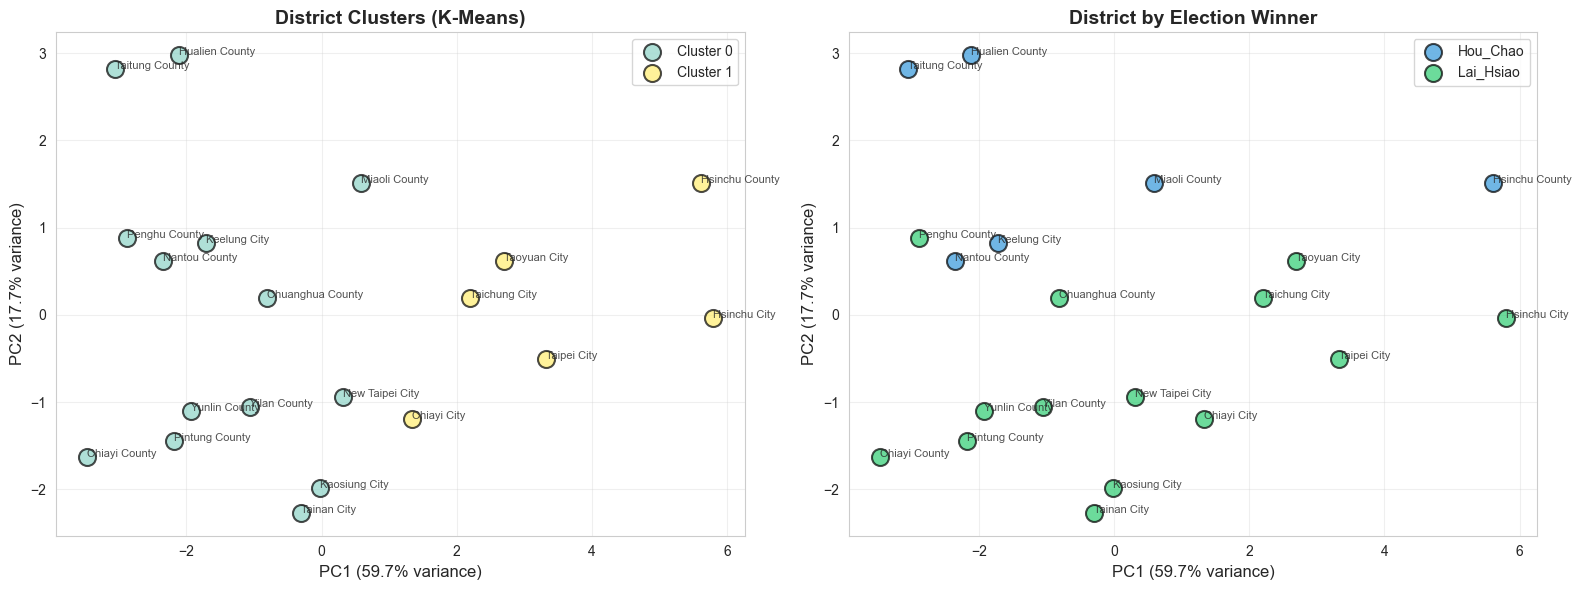

In [14]:
# Visualize clusters in 2D
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Colored by cluster
colors = plt.cm.Set3(np.linspace(0, 1, optimal_k))
for cluster_id in range(optimal_k):
    mask = clusters == cluster_id
    axes[0].scatter(
        X_pca[mask, 0], X_pca[mask, 1],
        c=[colors[cluster_id]], s=150, alpha=0.7,
        edgecolor='black', linewidth=1.5,
        label=f'Cluster {cluster_id}'
    )
    
    # Add district labels
    for i, district in enumerate(districts[mask]):
        axes[0].annotate(
            district, 
            (X_pca[mask, 0][i], X_pca[mask, 1][i]),
            fontsize=8, alpha=0.8
        )

axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
axes[0].set_title('District Clusters (K-Means)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Colored by winner
winner_colors = {'Lai_Hsiao': '#2ecc71', 'Hou_Chao': '#3498db', 'Ko_Wu': '#e74c3c'}
for winner in np.unique(winners):
    mask = winners == winner
    axes[1].scatter(
        X_pca[mask, 0], X_pca[mask, 1],
        c=winner_colors[winner], s=150, alpha=0.7,
        edgecolor='black', linewidth=1.5,
        label=winner
    )
    
    # Add district labels
    for i, district in enumerate(districts[mask]):
        axes[1].annotate(
            district,
            (X_pca[mask, 0][i], X_pca[mask, 1][i]),
            fontsize=8, alpha=0.8
        )

axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
axes[1].set_title('District by Election Winner', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/cluster_visualization_pca.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Cluster Profiling

In [23]:
# Calculate cluster profiles (mean values)
cluster_profiles = df.groupby('Cluster')[clustering_features].mean()

print("\nCluster Profiles (Mean Values):")
print("="*80)
print(cluster_profiles.round(2))

# Save to CSV
cluster_profiles.to_csv('../results/cluster_profiles.csv')
print("\nCluster profiles saved to: results/cluster_profiles.csv")


Cluster Profiles (Mean Values):
         Age_0_14_Pct  Age_15_64_Pct  Age_65_Plus_Pct      Income  \
Cluster                                                             
0               10.73          69.26            20.01  1136232.00   
1               13.66          70.26            16.08  1654645.33   

         Disposable_Income  Consumption  Higher_Education_Pct  Graduate_Pct  \
Cluster                                                                       
0                954892.14    709347.36                 43.00          6.48   
1               1349409.17   1031197.67                 56.68         11.89   

         Avg_People_Per_HH  Lai_Hsiao_Pct  Hou_Chao_Pct  Ko_Wu_Pct  
Cluster                                                             
0                     2.64          39.38         35.40      25.21  
1                     2.93          36.07         33.98      29.94  

Cluster profiles saved to: results/cluster_profiles.csv


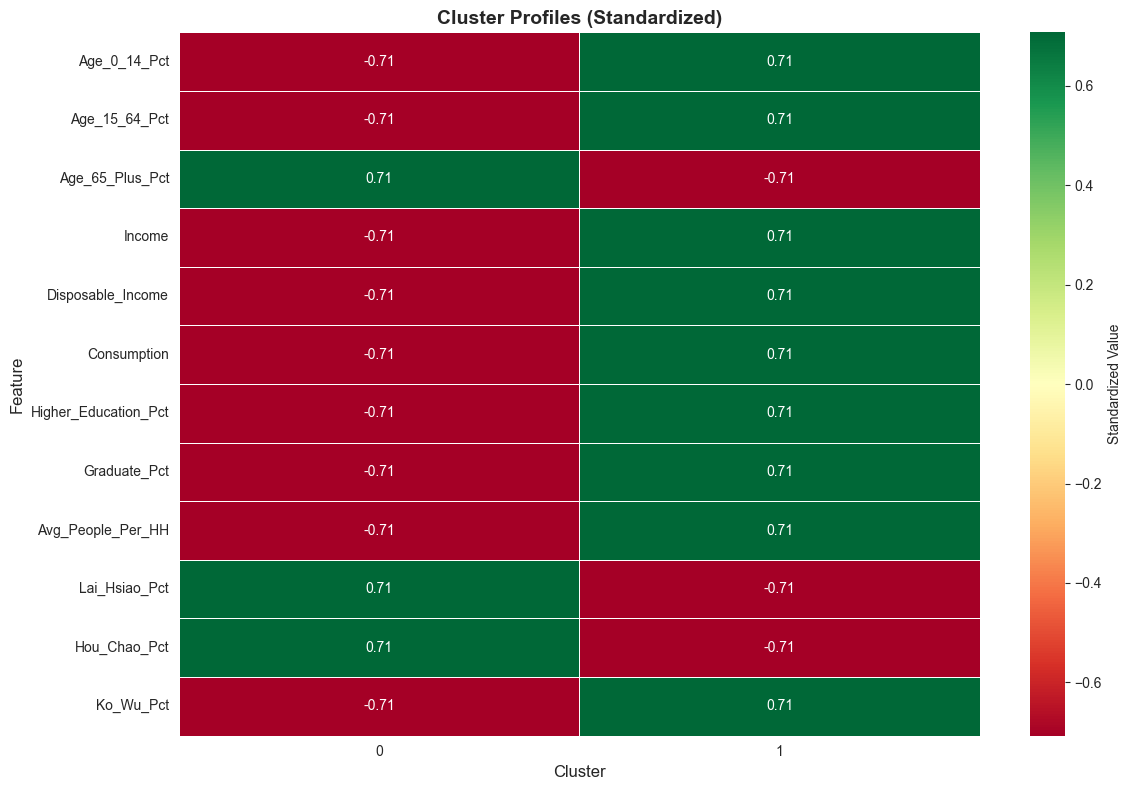

In [24]:
# Visualize cluster profiles with heatmap
plt.figure(figsize=(12, 8))

# Standardize for better visualization
cluster_profiles_std = (cluster_profiles - cluster_profiles.mean()) / cluster_profiles.std()

sns.heatmap(
    cluster_profiles_std.T,
    annot=True,
    fmt='.2f',
    cmap='RdYlGn',
    center=0,
    cbar_kws={'label': 'Standardized Value'},
    linewidths=0.5
)
plt.title('Cluster Profiles (Standardized)', fontsize=14, fontweight='bold')
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig('../results/figures/cluster_profiles_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Cluster Characteristics

In [ ]:
# Analyze voting patterns by cluster
md_text = "# CLUSTER CHARACTERISTICS\n\n"

for cluster_id in range(optimal_k):
    cluster_data = df[df['Cluster'] == cluster_id]
    
    md_text += f"## Cluster {cluster_id}\n\n"
    md_text += f"**Districts ({len(cluster_data)}):**\n"
    md_text += ", ".join(cluster_data['District'].values) + "\n\n"
    
    md_text += "**Demographics:**\n"
    md_text += f"- Elderly (65+): {cluster_data['Age_65_Plus_Pct'].mean():.1f}%\n"
    md_text += f"- Youth (0-14): {cluster_data['Age_0_14_Pct'].mean():.1f}%\n"
    md_text += f"- Working Age (15-64): {cluster_data['Age_15_64_Pct'].mean():.1f}%\n\n"
    
    md_text += "**Economics:**\n"
    md_text += f"- Avg Income: {cluster_data['Income'].mean():,.0f} TWD\n"
    md_text += f"- Disposable Income: {cluster_data['Disposable_Income'].mean():,.0f} TWD\n\n"
    
    md_text += "**Education:**\n"
    md_text += f"- Higher Education: {cluster_data['Higher_Education_Pct'].mean():.1f}%\n"
    md_text += f"- Graduate Degree: {cluster_data['Graduate_Pct'].mean():.1f}%\n\n"
    
    md_text += "**Voting Pattern:**\n"
    winner_counts = cluster_data['Winner'].value_counts()
    for winner, count in winner_counts.items():
        md_text += f"- {winner}: {count} districts ({count/len(cluster_data)*100:.0f}%)\n\n"
    
    md_text += "**Average Vote Shares:**\n"
    md_text += f"- Lai-Hsiao: {cluster_data['Lai_Hsiao_Pct'].mean():.1f}%\n"
    md_text += f"- Hou-Chao: {cluster_data['Hou_Chao_Pct'].mean():.1f}%\n"
    md_text += f"- Ko-Wu: {cluster_data['Ko_Wu_Pct'].mean():.1f}%\n\n"
    md_text += "---\n\n"

with open("../results/cluster_analysis.md", "w", encoding="utf-8") as f:
    f.write(md_text)

print("Markdown file saved!")


Markdown file saved!


## 7. Cluster Naming and Interpretation

In [ ]:
# Create descriptive names for clusters
cluster_names = {}

for cluster_id in range(optimal_k):
    cluster_data = df[df['Cluster'] == cluster_id]
    
    # Determine cluster type based on characteristics
    avg_age_65 = cluster_data['Age_65_Plus_Pct'].mean()
    avg_income = cluster_data['Income'].mean()
    avg_education = cluster_data['Higher_Education_Pct'].mean()
    
    # Create name
    age_label = "Aging" if avg_age_65 > 19 else "Young"
    income_label = "High-Income" if avg_income > 1400000 else "Middle-Income"
    edu_label = "Highly-Educated" if avg_education > 50 else "Moderate-Education"
    
    cluster_names[cluster_id] = f"{age_label} {income_label} {edu_label}"

# Add names to dataframe
df['Cluster_Name'] = df['Cluster'].map(cluster_names)

print("\n" + "="*80)
print("CLUSTER TYPOLOGY")
print("="*80)
for cluster_id, name in cluster_names.items():
    districts_in_cluster = df[df['Cluster'] == cluster_id]['District'].values
    print(f"\nCluster {cluster_id}: {name}")
    print(f"  Districts: {', '.join(districts_in_cluster)}")


CLUSTER TYPOLOGY

Cluster 0: Aging Middle-Income Moderate-Education
  Districts: New Taipei City, Tainan City, Kaosiung City, Yilan County, Miaoli County, Chuanghua County, Nantou County, Yunlin County, Chiayi County, Pintung County, Taitung County, Hualien County, Penghu County, Keelung City

Cluster 1: Young High-Income Highly-Educated
  Districts: Taipei City, Taoyuan City, Taichung City, Hsinchu County, Hsinchu City, Chiayi City


## 8. Voting Behavior by Cluster

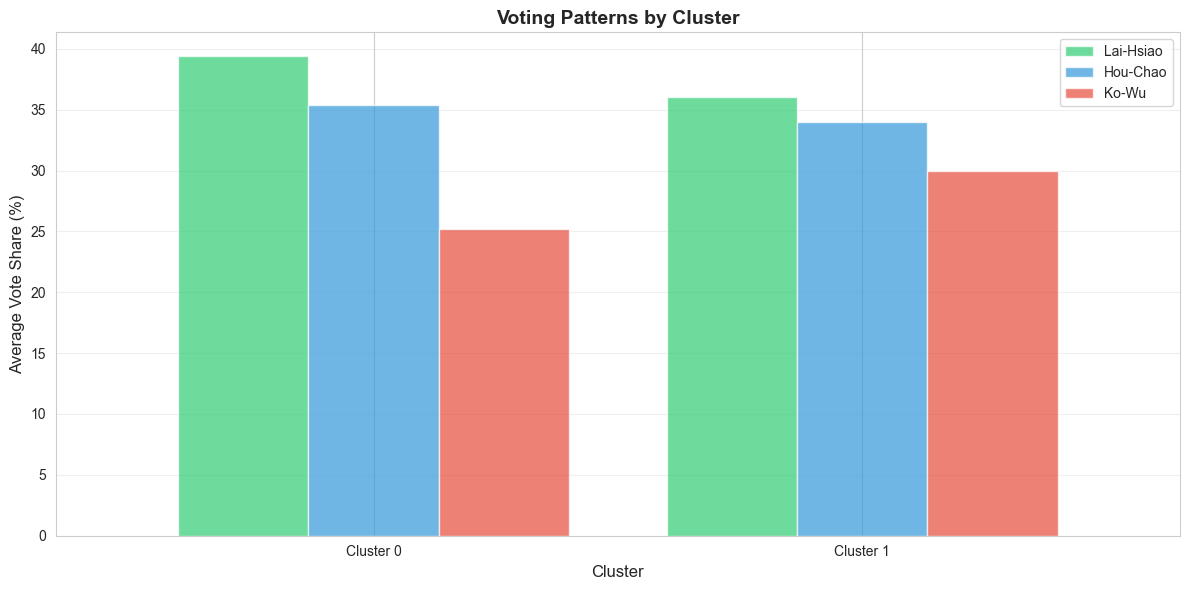

In [19]:
# Visualize voting patterns by cluster
vote_cols = ['Lai_Hsiao_Pct', 'Hou_Chao_Pct', 'Ko_Wu_Pct']
cluster_voting = df.groupby('Cluster')[vote_cols].mean()

fig, ax = plt.subplots(figsize=(12, 6))
cluster_voting.plot(kind='bar', ax=ax, color=['#2ecc71', '#3498db', '#e74c3c'], alpha=0.7, width=0.8)

ax.set_xlabel('Cluster', fontsize=12)
ax.set_ylabel('Average Vote Share (%)', fontsize=12)
ax.set_title('Voting Patterns by Cluster', fontsize=14, fontweight='bold')
ax.set_xticklabels([f"Cluster {i}" for i in range(optimal_k)], rotation=0)
ax.legend(['Lai-Hsiao', 'Hou-Chao', 'Ko-Wu'], loc='upper right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/cluster_voting_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. Save Results

In [ ]:
# Save clustered data
output_cols = ['District', 'Cluster', 'Cluster_Name', 'Winner'] + clustering_features
df[output_cols].to_csv('../results/clustered_districts.csv', index=False)

print("Clustering results saved to: results/clustered_districts.csv")
print("\nSample output:")
print(df[output_cols].head(10))

✓ Clustering results saved to: results/clustered_districts.csv

Sample output:
           District  Cluster                            Cluster_Name  \
0       Taipei City        1       Young High-Income Highly-Educated   
1   New Taipei City        0  Aging Middle-Income Moderate-Education   
2      Taoyuan City        1       Young High-Income Highly-Educated   
3     Taichung City        1       Young High-Income Highly-Educated   
4       Tainan City        0  Aging Middle-Income Moderate-Education   
5     Kaosiung City        0  Aging Middle-Income Moderate-Education   
6      Yilan County        0  Aging Middle-Income Moderate-Education   
7    Hsinchu County        1       Young High-Income Highly-Educated   
8     Miaoli County        0  Aging Middle-Income Moderate-Education   
9  Chuanghua County        0  Aging Middle-Income Moderate-Education   

      Winner  Age_0_14_Pct  Age_15_64_Pct  Age_65_Plus_Pct   Income  \
0  Lai_Hsiao         11.28          70.61            18.1

## 10. Key Insights

In [26]:
print("\n" + "="*80)
print("KEY INSIGHTS FROM CLUSTERING ANALYSIS")
print("="*80)

print(f"\n[1] Optimal Number of Clusters: {optimal_k}")
print(f"    Silhouette Score: {max(silhouette_scores):.3f}")

print(f"\n[2] Cluster Distribution:")
for cluster_id in range(optimal_k):
    count = (df['Cluster'] == cluster_id).sum()
    print(f"    - {cluster_names[cluster_id]}: {count} districts")

print(f"\n[3] Voting Patterns by Cluster Type:")
for cluster_id in range(optimal_k):
    cluster_data = df[df['Cluster'] == cluster_id]
    dominant_winner = cluster_data['Winner'].mode()[0]
    winner_pct = (cluster_data['Winner'] == dominant_winner).sum() / len(cluster_data) * 100
    print(f"    - {cluster_names[cluster_id]}: {dominant_winner} dominates ({winner_pct:.0f}%)")

print(f"\n[4] Key Differentiators:")
# Find features with highest variance across clusters
cluster_variance = cluster_profiles.var().sort_values(ascending=False)
print("    Top 3 features that distinguish clusters:")
for i, (feature, variance) in enumerate(cluster_variance.head(3).items(), 1):
    print(f"    {i}. {feature}")

print("\n" + "="*80)


KEY INSIGHTS FROM CLUSTERING ANALYSIS

[1] Optimal Number of Clusters: 2
    Silhouette Score: 0.363

[2] Cluster Distribution:
    - Aging Middle-Income Moderate-Education: 14 districts
    - Young High-Income Highly-Educated: 6 districts

[3] Voting Patterns by Cluster Type:
    - Aging Middle-Income Moderate-Education: Lai_Hsiao dominates (64%)
    - Young High-Income Highly-Educated: Lai_Hsiao dominates (83%)

[4] Key Differentiators:
    Top 3 features that distinguish clusters:
    1. Income
    2. Disposable_Income
    3. Consumption

